# Analyse av anki-data
Gjort ved hjelp av python og pandas.

In [2]:
from datetime import datetime
import pandas as pd

In [3]:
df = pd.read_csv("anki-reviews.csv")
df["date"] = ( # Lese og behandle datoer
    pd.to_datetime(df["id"], unit="ms")
    .dt.tz_localize("UTC")
    .dt.tz_convert("Europe/Oslo")
)
df["hour"] = df["date"].dt.hour
df["time"] = pd.to_timedelta(df["time"], unit="ms")
df["ivl"] = df["ivl"].apply( # Se readme. Sekunder hvis negativt, ellers dager.
    lambda x: pd.to_timedelta(x, unit="D") if x > 0 else pd.to_timedelta(-x, unit="s")
)
df["lastIvl"] = df["lastIvl"].apply(
    lambda x: pd.to_timedelta(x, unit="D") if x > 0 else pd.to_timedelta(-x, unit="s")
)

Jeg oppretter en kolonne `"efficiency"`, med formelen
$$
\text{efficiency} = \frac{\text{ease}}{\text{time}}
$$
Denne kan gi meg et mål på hvor bra jeg gjorde en spesifikk review.

In [4]:
df["efficiency"] = df["ease"] / df["time"].dt.total_seconds()
df

,id,cid,usn,ease,ivl,lastIvl,factor,time,type,date,hour,efficiency
0,1645550962771,1645550870303,0,3,0 days 00:10:00,0 days 00:01:00,0,0 days 00:00:15.705000,0,2022-02-22 18:29:22.771000+01:00,18,0.191022
1,1645550969526,1645550878622,0,3,0 days 00:10:00,0 days 00:01:00,0,0 days 00:00:06.753000,0,2022-02-22 18:29:29.526000+01:00,18,0.444247
2,1645550970913,1645550884416,0,3,0 days 00:10:00,0 days 00:01:00,0,0 days 00:00:01.385000,0,2022-02-22 18:29:30.913000+01:00,18,2.166065
3,1645550972018,1645550888136,0,3,0 days 00:10:00,0 days 00:01:00,0,0 days 00:00:01.102000,0,2022-02-22 18:29:32.018000+01:00,18,2.722323
4,1645550977062,1645550878622,0,3,1 days 00:00:00,0 days 00:10:00,2500,0 days 00:00:05.042000,0,2022-02-22 18:29:37.062000+01:00,18,0.595002
...,...,...,...,...,...,...,...,...,...,...,...,...
17036,1738911261637,1734801994355,189,3,1 days 00:00:00,0 days 00:10:00,2500,0 days 00:00:01.634000,0,2025-02-07 07:54:21.637000+01:00,7,1.835985
17037,1738911265074,1734801968577,189,3,1 days 00:00:00,0 days 00:10:00,2500,0 days 00:00:03.327000,0,2025-02-07 07:54:25.074000+01:00,7,0.901713
17038,1738911268197,1734801993382,189,3,1 days 00:00:00,0 days 00:10:00,2500,0 days 00:00:03.011000,0,2025-02-07 07:54:28.197000+01:00,7,0.996347
17039,1738911271684,1734801992150,189,3,1 days 00:00:00,0 days 00:10:00,2500,0 days 00:00:03.378000,0,2025-02-07 07:54:31.684000+01:00,7,0.888099


`cards` inneholder kun den siste reviewen av et kort. Dette vil vise hvor godt jeg husker innholdet per nå, i stedet for alle gangene jeg har sett kortet.

In [5]:
cards = df.drop_duplicates(subset="cid", keep="last")

## Reviews over tid

Her ser jeg at det har vært perioder der jeg gjør mange flere og mange færre reviews. I sommerferien og før skolen startet i 2024, hadde jeg veldig få reviews, og etter skolen startet økte det.

Text(0.5, 1.0, 'Review distribution over time')

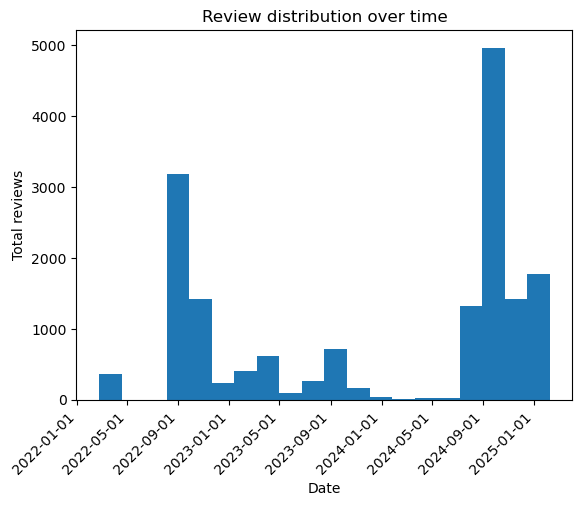

In [4]:
ax = df["date"].hist(grid=False, bins=20)
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")
ax.set_xlabel("Date")
ax.set_ylabel("Total reviews")
ax.set_title("Review distribution over time")

## Kort-typer

Her bruker jeg `cards` slik at jeg ser distribusjonen av kortene mellom de ulike stadiene. De ulike stadiene er dokumentert i [anki sin dokumentasjon](https://docs.ankiweb.net/getting-started.html#card-states).

Her ser jeg, som forventet, at mesteparten av kortene jeg har (rundt 2500), er i "Review"-stadiet, som betyr at jeg har lært innholdet og holder det ved like. "Learning" er på rundt 500, som betyr at jeg har ganske mange kort jeg har sett før, men som jeg ikke har lært enda.

Text(0.5, 1.0, 'Card type distribution')

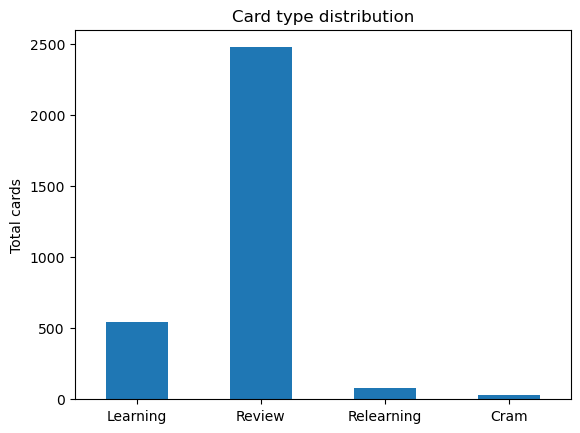

In [13]:
ax = cards["type"].value_counts(sort=False).plot(kind="bar")
ax.set_xticklabels(["Learning", "Review", "Relearning", "Cram"], rotation=0)
ax.set_xlabel("")
ax.set_ylabel("Total cards")
ax.set_title("Card type distribution")

## Review ease

Ease viser hvor godt jeg kan et kort, fra Again til Easy etter hvor godt jeg husket det. Dette viser at de fleste gangene jeg har et kort, velger jeg "Good" eller "Again", der again betyr at jeg vil se kortet på nytt, og good betyr at det vil gå en lengre periode til jeg ser det på nytt. Jeg har mange færre på "Hard" og "Easy", som er fordi jeg har valgt selv å trykke de to andre valgene på de fleste av kortene, siden jeg synes resultatene passer bedre fra det.

Text(0.5, 1.0, 'Review ease distribution')

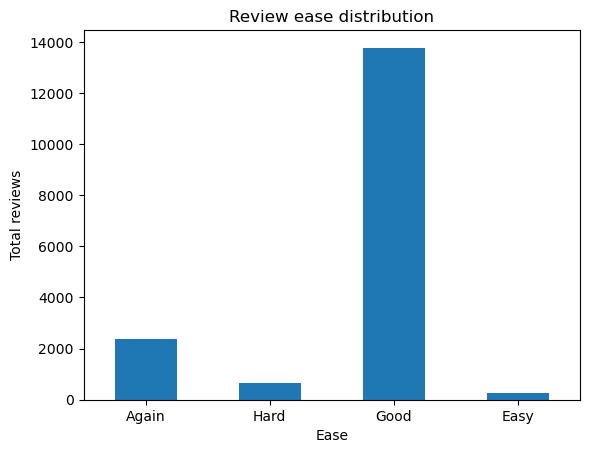

In [7]:
ax = df["ease"].value_counts().sort_index().plot(kind="bar", xlabel="")
ax.set_xticklabels(["Again", "Hard", "Good", "Easy"], rotation=0)
ax.set_xlabel("Ease")
ax.set_ylabel("Total reviews")
ax.set_title("Review ease distribution")

### Kort ease

Dette er den samme statistikken, men jeg undersøker per kort med den siste review, heller enn å sjekke hver eneste review. Der ser jeg at det er en mye større andel kort på Good, som da viser at jeg over tid har lært flere av kortene og dermed valgt Good.

Text(0.5, 1.0, 'Card ease distribution')

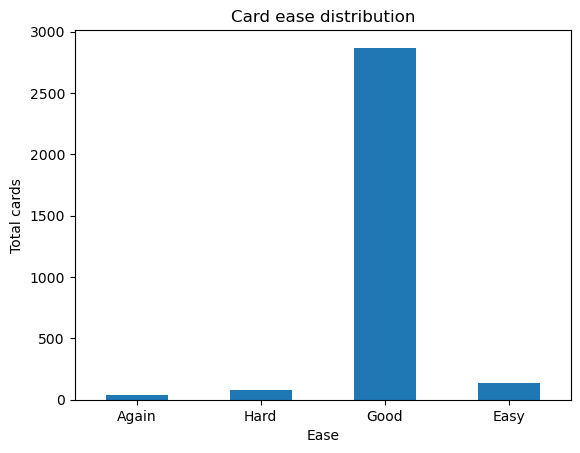

In [6]:
ax = cards["ease"].value_counts().sort_index().plot(kind="bar", xlabel="")
ax.set_xticklabels(["Again", "Hard", "Good", "Easy"], rotation=0)
ax.set_xlabel("Ease")
ax.set_ylabel("Total cards")
ax.set_title("Card ease distribution")

## Tid per review

Dette viser at de fleste kort blir jeg ferdig med etter under 5 sekunder. Grunnen til at det er flere ved 60 er sannsynligvis at den stopper å telle etter den tiden, og dermed vil den registrere alle der tiden brukt er mer enn 60 sekunder, som 60 sekunder.

Text(0.5, 1.0, 'Time spent per review in seconds')

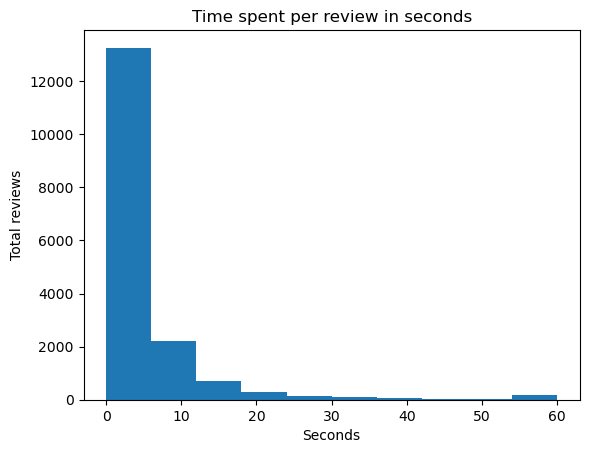

In [45]:
ax = df["time"].dt.total_seconds().hist(grid=False)
ax.set_xlabel("Seconds")
ax.set_ylabel("Total reviews")
ax.set_title("Time spent per review in seconds")

## Intervall

Intervallet til et kort forteller hvor lang tid det tar til neste gang jeg ser kortet. Det øker når jeg trykker good, og synker når jeg trykker again. De fleste av kortene mine er på under 200 dager, med noen få rundt 450 og 650 dager. Grunnen til at det er mer konsentrert i disse områdene, antar jeg er fordi når man trykker på knappen, blir det tidligere intervallet multiplisert med en konstant, slik at flere ender opp i det området.

Text(0.5, 1.0, 'Card interval distribution')

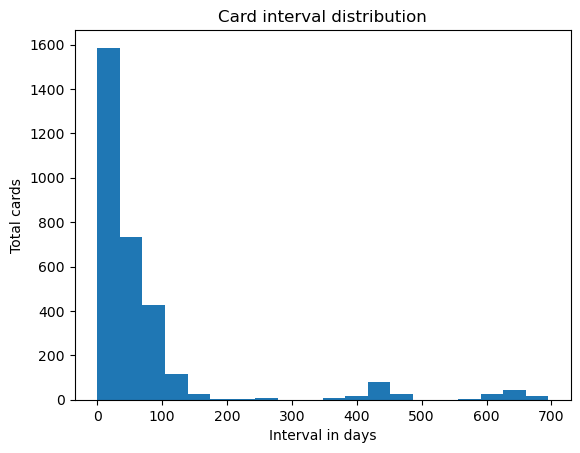

In [65]:
ax = cards["ivl"].dt.days.hist(grid=False, bins=20)
ax.set_xlabel("Interval in days")
ax.set_ylabel("Total cards")
ax.set_title("Card interval distribution")

## Reviews etter ukedager

De fleste reviews gjør jeg på hverdager, mens jeg tar mer pauser fra det i helgen. Mandager gjør jeg flest reviews, siden det har bygget seg opp flere og flere kort i helgen som jeg til slutt gjør på mandag.

Text(0.5, 1.0, 'Reviews by weekday')

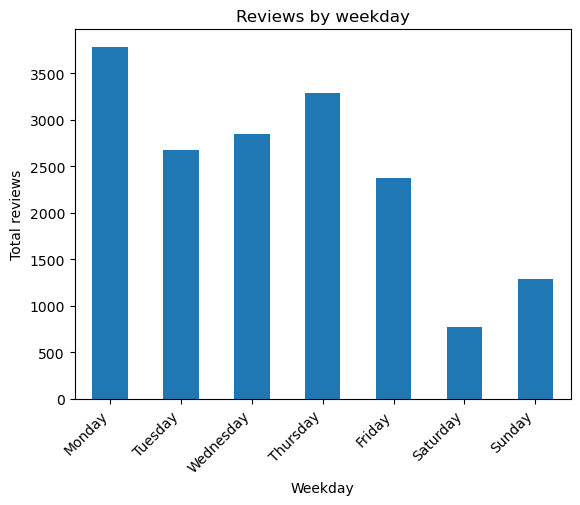

In [71]:
ax = df["date"].dt.weekday.value_counts().sort_index().plot(kind="bar")
ax.set_xticklabels(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"],
    rotation=45,
    ha="right",
)
ax.set_xlabel("Weekday")
ax.set_ylabel("Total reviews")
ax.set_title("Reviews by weekday")

## Reviews etter tid på dagen

Ut fra dette ser jeg at de fleste reviews blir gjort rundt klokken 7 på morgenen. Dette er den tiden jeg sitter på bybanen på vei til skolen, så jeg gjør de fleste i den tidsperioden. Fra 21-22 antar jeg det er fordi jeg på slutten av dagen kommer på å gå gjennom kortene, og derfor blir det flere før jeg legger meg. Samtidig synker antall reviews om dagen når jeg er på skolen, siden jeg holder på med andre fag.

Text(0.5, 1.0, 'Reviews by time of day')

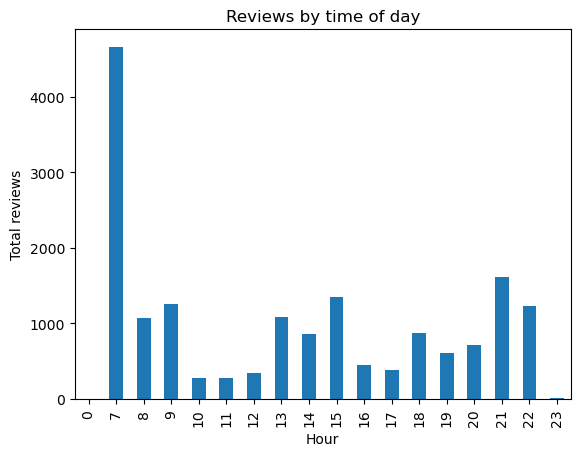

In [64]:
ax = df["hour"].value_counts().sort_index().plot(kind="bar", xlabel="")
ax.set_xlabel("Hour")
ax.set_ylabel("Total reviews")
ax.set_title("Reviews by time of day")

## Effektivitet av reviews

Her bruker jeg kolonnen med formelen fra tidligere. Jeg ser at rundt klokken ett er jeg svært mye mer effektiv enn på andre tidspunkter på dagen. Dette skyldes kanskje at på den tiden er jeg mer våken og gjør dermed alle reviews raskere.

Text(0, 0.5, 'Average efficiency (ease / time)')

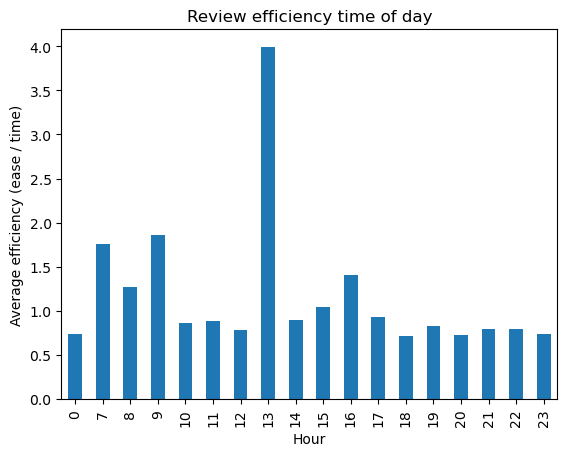

In [8]:
ax = df.groupby("hour")["efficiency"].mean().plot(kind="bar")
ax.set_title("Review efficiency time of day")
ax.set_xlabel("Hour")
ax.set_ylabel("Average efficiency (ease / time)")

Når jeg undersøker dette videre, ser jeg at rundt januar 2024, er det et t

Text(0, 0.5, 'Efficiency')

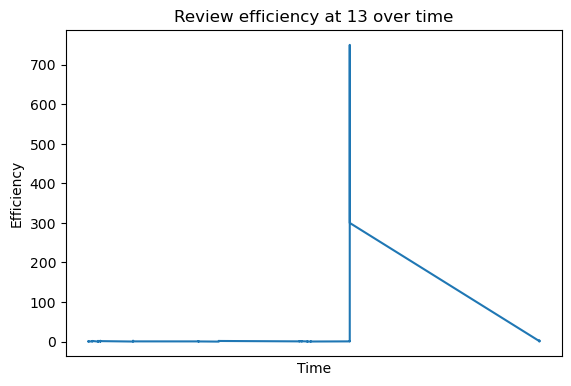

In [15]:
reviews_at_13 = df.groupby("hour").get_group(13)
ax = reviews_at_13.plot(kind="line", x="date", y="efficiency", legend=False)
ax.set_title("Review efficiency at 13 over time")
ax.set_xticks([])
ax.set_xlabel("Time")
ax.set_ylabel("Efficiency")

Jeg ser at det er et høyt antall verdier, så problemet er ikke at det er for få verdier å sammenligne.

In [51]:
len(reviews_at_13)

1087

Text(0, 0.5, 'Efficiency')

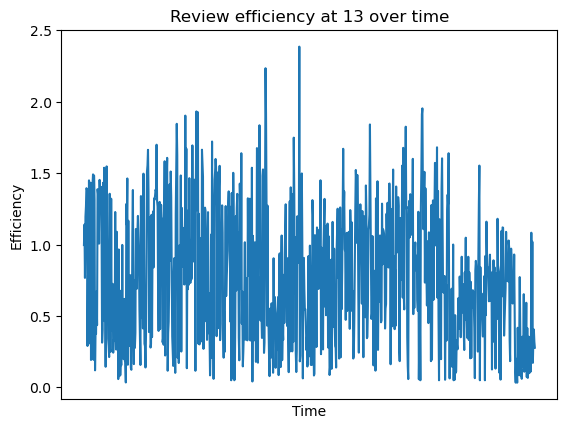

In [16]:
before_outlier = reviews_at_13[
    reviews_at_13["date"] < pd.to_datetime("2023-11-01").tz_localize("Europe/Oslo")
].copy() # copy so that the original df is not modified
before_outlier["date_str"] = before_outlier["date"].astype(str) # make it plot continuously without adding spacing for missing dates
ax = before_outlier.plot(kind="line", x="date_str", y="efficiency", legend=False)
ax.set_xticks([])
ax.set_xlabel("Time")
ax.set_title("Review efficiency at 13 over time")
ax.set_ylabel("Efficiency")

Når jeg plotter efficiency av alle reviews klokken 13, før november 2023, ser jeg at tallet ser mye jevnere ut. Dermed ser det ut som om at avviket skyldes en feil i datasettet, for eksempel at tiden for kortene ble registrert som et tall som er tilnærmet lik null, og dette endret da gjennomsnittet som ble brukt til å finne effektivitet per time.